In [4]:
from matplotlib import pyplot as plt

from pyloki.config import PulsarSearchConfig
from pyloki.search import ffa_search
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.utils import np_utils

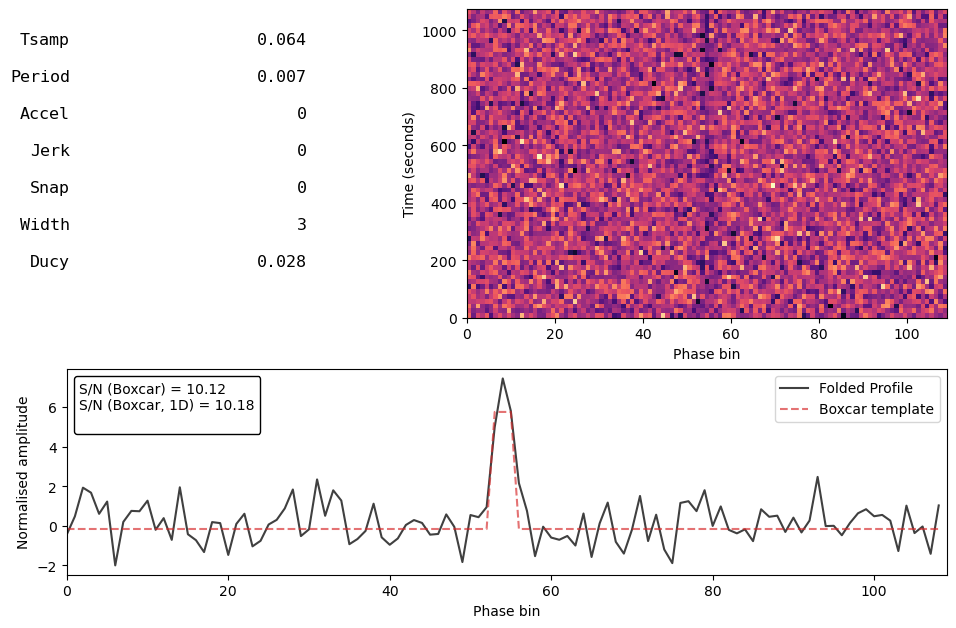

In [5]:
pulsar_period = 0.007  # (s)
dt = 64e-6
nsamps = 2**24
cfg = PulseSignalConfig(
    period=pulsar_period,
    dt=dt,
    snr=10,
    ducy=0.05,
    nsamps=nsamps,
    os=1,
)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins)
plt.show()

In [6]:
tol_bins = 2  # cfg.tol_bins
fold_bins = 64  # cfg.fold_bins
param_limits = [(1 / 0.0075, 1 / 0.0065)]
bseg_brute = cfg.nsamps // 2048
search_cfg = PulsarSearchConfig(
    nsamps=cfg.nsamps,
    tsamp=cfg.dt,
    nbins=fold_bins,
    tol_bins=tol_bins,
    param_limits=param_limits,
    bseg_brute=bseg_brute,
    ducy_max=0.2,
    wtsp=1.1,
)
dyp, pgram = ffa_search(tim_data, search_cfg)

2025-03-26 16:40:03 INFO     - pyloki.ffa - FFA initialize: Grid sizes: [0.05960464]

2025-03-26 16:40:04 INFO     - pyloki.ffa - ffa level:  0, leaves: 8.43, fold dims: (2048, 344, 2, 64)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 2.694 seconds

Output()

2025-03-26 16:40:08 INFO     - pyloki.ffa - ffa level:  1, leaves:  9.43, fold dims: (1024, 688, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  2, leaves: 10.43, fold dims: (512, 1376, 2, 64)

2025-03-26 16:40:09 INFO     - pyloki.ffa - ffa level:  3, leaves: 11.43, fold dims: (256, 2753, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  4, leaves: 12.43, fold dims: (128, 5506, 2, 64)

2025-03-26 16:40:10 INFO     - pyloki.ffa - ffa level:  5, leaves: 13.43, fold dims: (64, 11012, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  6, leaves: 14.43, fold dims: (32, 22025, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  7, leaves: 15.43, fold dims: (16, 44050, 2, 64)

2025-03-26 16:40:11 INFO     - pyloki.ffa - ffa level:  8, leaves: 16.43, fold dims: (8, 88101, 2, 64)

                    INFO     - pyloki.ffa - ffa level:  9, leaves: 17.43, fold dims: (4, 176203, 2, 64)

2025-03-26 16:40:12 INFO     - pyloki.ffa - ffa level: 10, leaves: 18.43, fold dims: (2, 352407, 2, 64)

2025-03-26 16:40:13 INFO     - pyloki.ffa - ffa level: 11, leaves: 19.43, fold dims: (1, 704815, 2, 64)

                    INFO     - pyloki.ffa - FFA complete: Grid sizes: [2.91038305e-05]

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 8.793 seconds

In [7]:
idx_freq = np_utils.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
true_params_idx = idx_freq
print(f"True param indices: {true_params_idx}")
print(f"Best param indices: {pgram.find_best_indices()}")
print(pgram.get_summary())

True param indices: 327235
Best param indices: (np.int64(327235), np.int64(1))
Best S/N: 8.97
Best Period: 0.007
Best freq: 142.85714285714286
Best width: 2


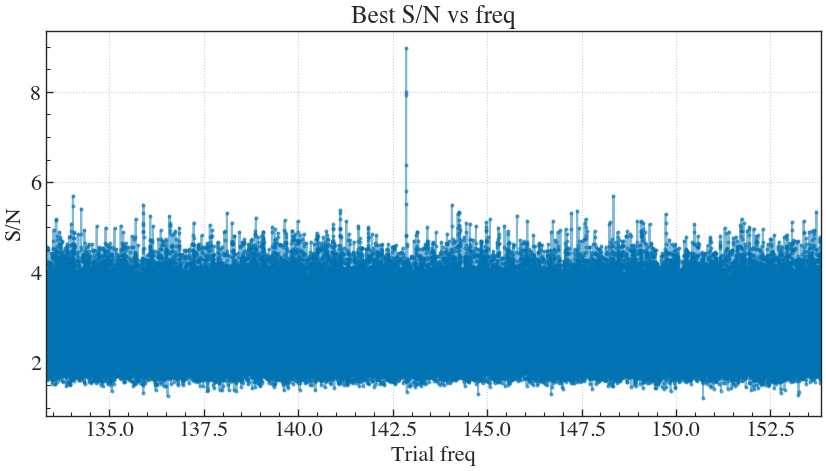

In [8]:
fig = pgram.plot_1d("freq", figsize=(10, 5))
plt.show()